# ESA Project: Fake or Real: The Impostor Hunt in Texts

This notebook is dedicated to **exploratory data analysis (EDA)**.  
It covers:

- Exploring the processed datasets generated in the data preparation notebook.  
- Visualizing label distributions and text lengths.  
- Generating insights to guide feature engineering and modeling.  
- Checking for anomalies or patterns in the text data.

# Import librairies

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
import os
import sys

# Add the src folder to Python path
sys.path.append(os.path.abspath(os.path.join('..', 'src')))
import config

sns.set_theme()

# Load datasets

In [2]:
# DATA_PATH = Path("../data/processed")
PLOTS_PATH = Path(config.OUTPUT_DIR / "plots")
PLOTS_PATH.mkdir(parents=True, exist_ok=True)

train_df = pd.read_csv(config.PROCESSED_DATA_DIR / "train_cleaned.csv")
val_df = pd.read_csv(config.PROCESSED_DATA_DIR / "val_cleaned.csv")

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)
print("\nTrain label distribution:\n", train_df['real_text_id'].value_counts())
print("\nValidation label distribution:\n", val_df['real_text_id'].value_counts())

Train shape: (74, 3)
Validation shape: (19, 3)

Train label distribution:
 real_text_id
2    38
1    36
Name: count, dtype: int64

Validation label distribution:
 real_text_id
2    10
1     9
Name: count, dtype: int64


# Quick Exploratory Data Analysis

## Text length features without considering label column

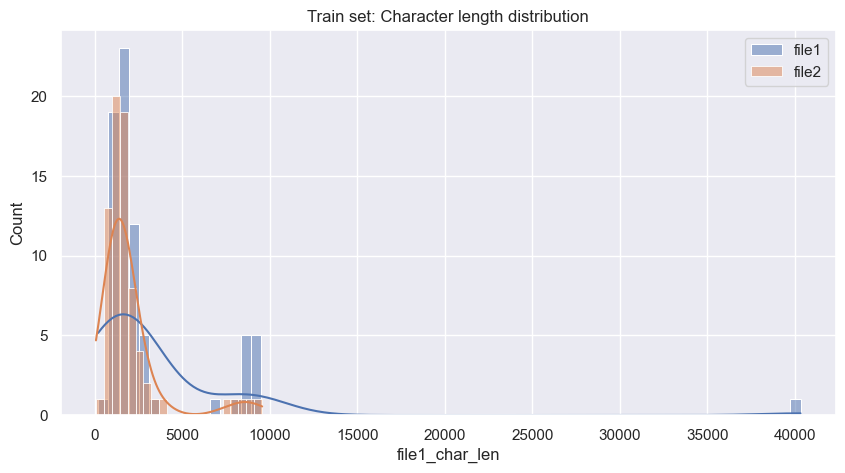

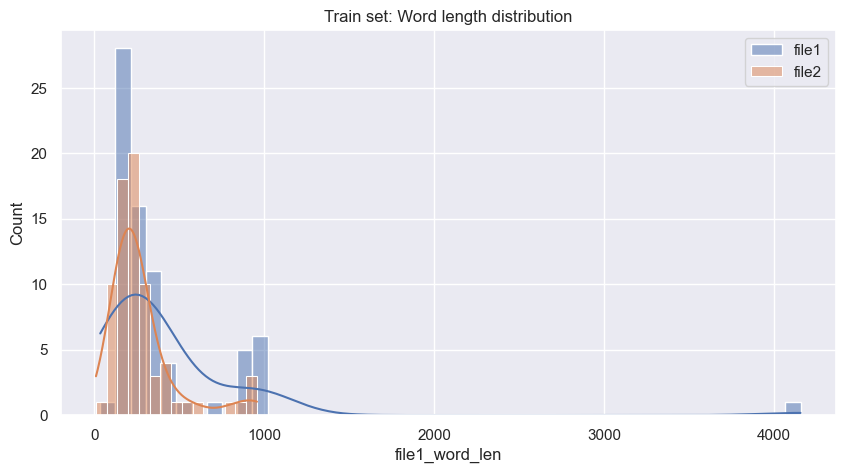

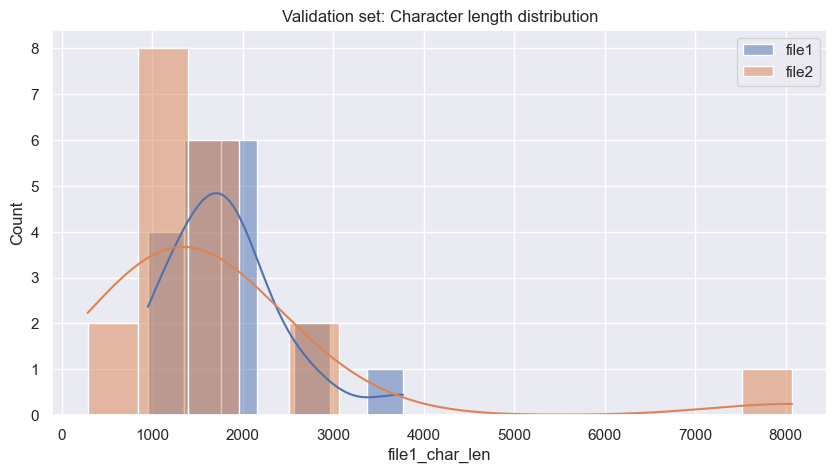

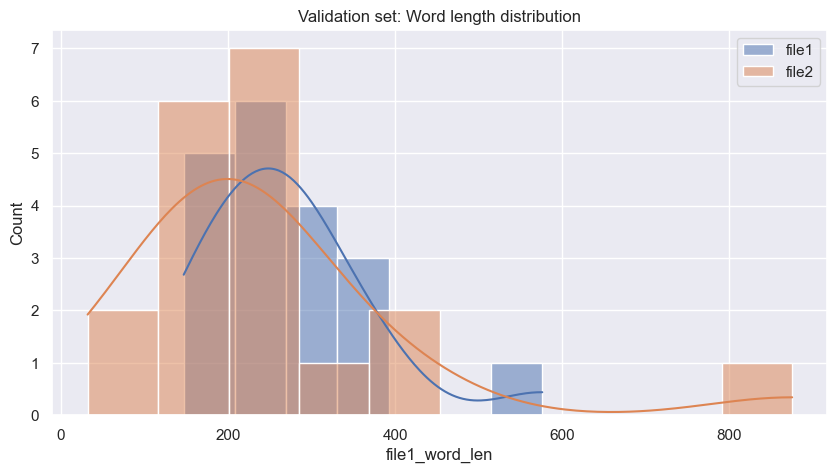

In [3]:
# Looping over both datasets - usinge the same logic for both datasets without duplicating code
for df, name in zip([train_df, val_df], ['train', 'validation']):
    # Count nb of characters in each text
    df['file1_char_len'] = df['file1_text'].apply(len)
    df['file2_char_len'] = df['file2_text'].apply(len)
    # Count nb of words in each text
    df['file1_word_len'] = df['file1_text'].apply(lambda x: len(str(x).split()))
    df['file2_word_len'] = df['file2_text'].apply(lambda x: len(str(x).split()))
    
    # Plot histograms
    plt.figure(figsize=(10,5))
    sns.histplot(df['file1_char_len'], label='file1', kde=True)
    sns.histplot(df['file2_char_len'], label='file2', kde=True)
    plt.title(f"{name.capitalize()} set: Character length distribution")
    plt.legend()
    plt.savefig(PLOTS_PATH / f"{name}_char_len_dist.png")
    plt.show()
    
    plt.figure(figsize=(10,5))
    sns.histplot(df['file1_word_len'], label='file1', kde=True)
    sns.histplot(df['file2_word_len'], label='file2', kde=True)
    plt.title(f"{name.capitalize()} set: Word length distribution")
    plt.legend()
    plt.savefig(PLOTS_PATH / f"{name}_word_len_dist.png")
    plt.show()


## Text length features considering label column

,label,text,char_len,word_len
0,real,We determine accurate values for the total lit...,2525,406
1,fake,We determine accurate values for the total lit...,7101,751
2,real,The QUEST camera has 160 megapixels and was cr...,1368,219
3,fake,The 160-megapixel **Edam** camera was designed...,2076,337
4,real,The VLT has enabled two major projects using t...,1400,206


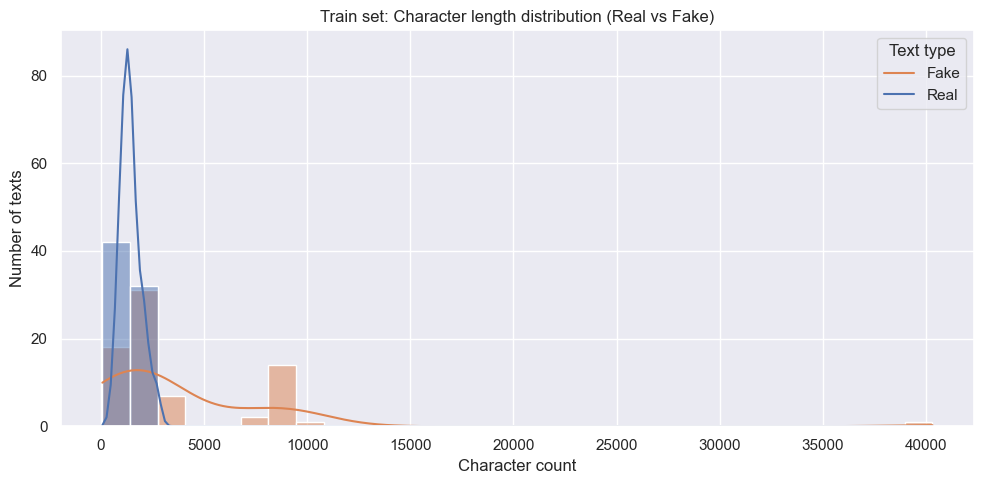

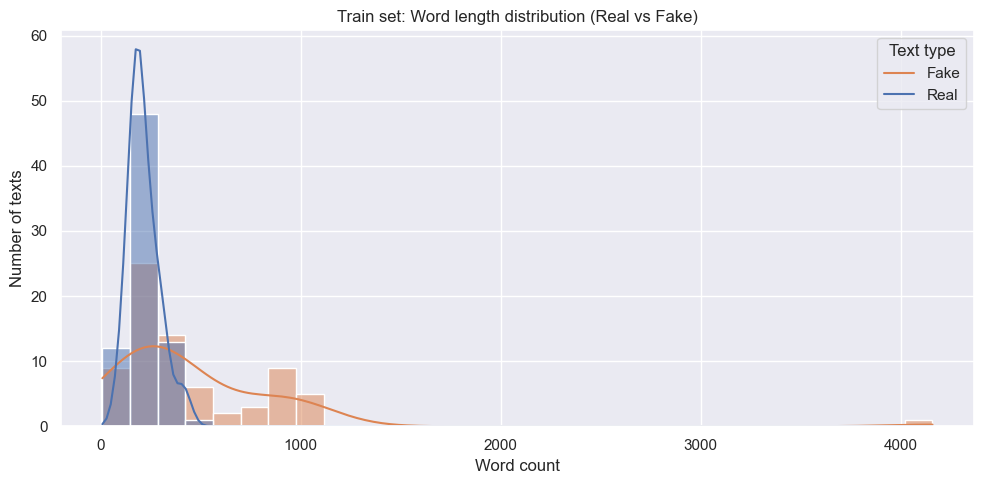

,label,text,char_len,word_len
0,real,Understanding the reionization of the universe...,1406,219
1,fake,## Peering into the Cosmic Abyss: Unlocking th...,3770,576
2,real,The multi-epoch approach has demonstrated its ...,2720,383
3,fake,Ancient civilizations left us not just incredi...,1346,208
4,real,The importance for understanding how stars evo...,1869,262


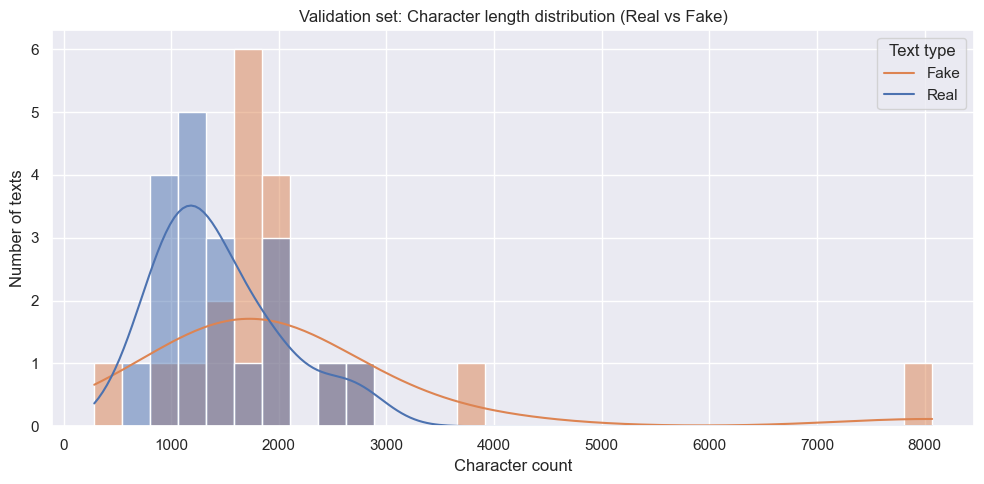

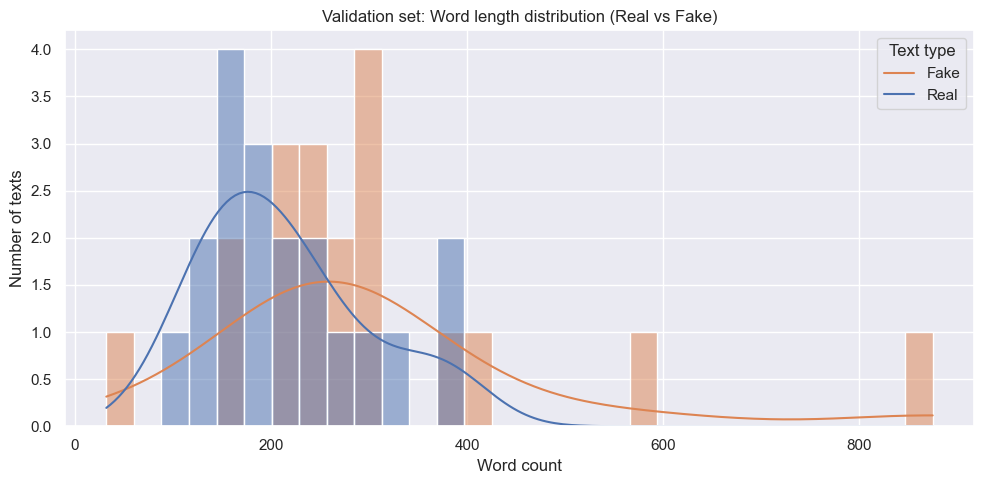

In [4]:
# Function to build real/fake view
def build_real_fake_view(df):
    rows = []
    for _, row in df.iterrows():
        # Real text
        if row["real_text_id"] == 1:
            real_text = row["file1_text"]
            fake_text = row["file2_text"]
        else:
            real_text = row["file2_text"]
            fake_text = row["file1_text"]

        rows.append({"label": "real", "text": real_text})
        rows.append({"label": "fake", "text": fake_text})
    return pd.DataFrame(rows)

# Function to build real/fake view and add length features
def build_real_fake_view_with_lengths(df):
    real_fake_df = build_real_fake_view(df)
    real_fake_df["char_len"] = real_fake_df["text"].str.len()
    real_fake_df["word_len"] = real_fake_df["text"].apply(lambda x: len(str(x).split()))
    return real_fake_df

# Loop over train and validation sets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    real_fake_df = build_real_fake_view_with_lengths(df)
    
    display(real_fake_df.head())  # optional, check first rows
    
    # Plot character length distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(data=real_fake_df, x="char_len", hue="label", kde=True, bins=30)
    plt.title(f"{name.capitalize()} set: Character length distribution (Real vs Fake)")
    plt.xlabel("Character count")
    plt.ylabel("Number of texts")
    plt.legend(title="Text type", labels=["Fake", "Real"])
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"{name}_char_len_real_fake_dist.png")
    plt.show()

    # Plot word length distribution
    plt.figure(figsize=(10, 5))
    sns.histplot(data=real_fake_df, x="word_len", hue="label", kde=True, bins=30)
    plt.title(f"{name.capitalize()} set: Word length distribution (Real vs Fake)")
    plt.xlabel("Word count")
    plt.ylabel("Number of texts")
    plt.legend(title="Text type", labels=["Fake", "Real"])
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"{name}_word_len_real_fake_dist.png")
    plt.show()


In [5]:
for df, name in zip([train_df, val_df], ['train', 'validation']):
    # Build real/fake view and add lengths
    real_fake_df = build_real_fake_view_with_lengths(df)
    
    print(f"\n{'='*80}")
    print(f"Descriptive statistics for {name} set")
    print(f"{'='*80}\n")
    
    # Loop over labels
    for label in ['real', 'fake']:
        print('-' * 80)
        print(f'Texts labeled "{label}"')
        print('-' * 80)
        
        subset = real_fake_df[real_fake_df['label'] == label]
        display(subset[['char_len', 'word_len']].describe())


Descriptive statistics for train set

--------------------------------------------------------------------------------
Texts labeled "real"
--------------------------------------------------------------------------------


,char_len,word_len
count,74.000000,74.000000
mean,1438.216216,215.743243
std,488.062939,76.868694
min,552.000000,75.000000
25%,1107.000000,167.000000
50%,1370.500000,199.000000
75%,1667.250000,255.500000
max,2734.000000,446.000000


--------------------------------------------------------------------------------
Texts labeled "fake"
--------------------------------------------------------------------------------


,char_len,word_len
count,74.000000,74.000000
mean,3845.121622,471.648649
std,5238.536126,527.368173
min,69.000000,9.000000
25%,1428.250000,213.250000
50%,1949.000000,296.500000
75%,3860.750000,601.750000
max,40316.000000,4158.000000



Descriptive statistics for validation set

--------------------------------------------------------------------------------
Texts labeled "real"
--------------------------------------------------------------------------------


,char_len,word_len
count,19.000000,19.000000
mean,1443.210526,213.842105
std,568.252641,83.847920
min,658.000000,98.000000
25%,1050.500000,154.500000
50%,1298.000000,199.000000
75%,1758.500000,250.000000
max,2720.000000,383.000000


--------------------------------------------------------------------------------
Texts labeled "fake"
--------------------------------------------------------------------------------


,char_len,word_len
count,19.000000,19.000000
mean,2132.684211,303.315789
std,1606.789382,177.229936
min,285.000000,32.000000
25%,1507.000000,226.500000
50%,1774.000000,263.000000
75%,2018.500000,302.500000
max,8070.000000,875.000000


__Real texts :__
- Train set: mean ~1440 characters (~216 words)
- Validation set: very similar, mean ~1443 characters (~214 words)
- The distributions are fairly consistent across train/validation.
- The word and character lengths are tightly clustered, as std is much smaller than for fake texts.

__Fake texts :__
- Train set: mean ~3845 characters (~472 words), but huge variability (std ~5238 chars). The max value is over 40k - characters, which is an extreme outlier.
- Validation set: mean ~2133 characters (~303 words), std (~1607 chars), still variable but smaller than train set.
- Fake texts are generally much longer than real texts with occasional extreme outliers.

__As a highlight :__
- Real texts are more uniform in length.
- Fake texts are more variable and often much longer.
- This difference can be very informative for modeling : a classifier could use length features as part of the decision.
- The huge outlier in the train set for fake texts (40k chars) might need preprocessing or truncation.

## Top TF-IDF words for real vs fake

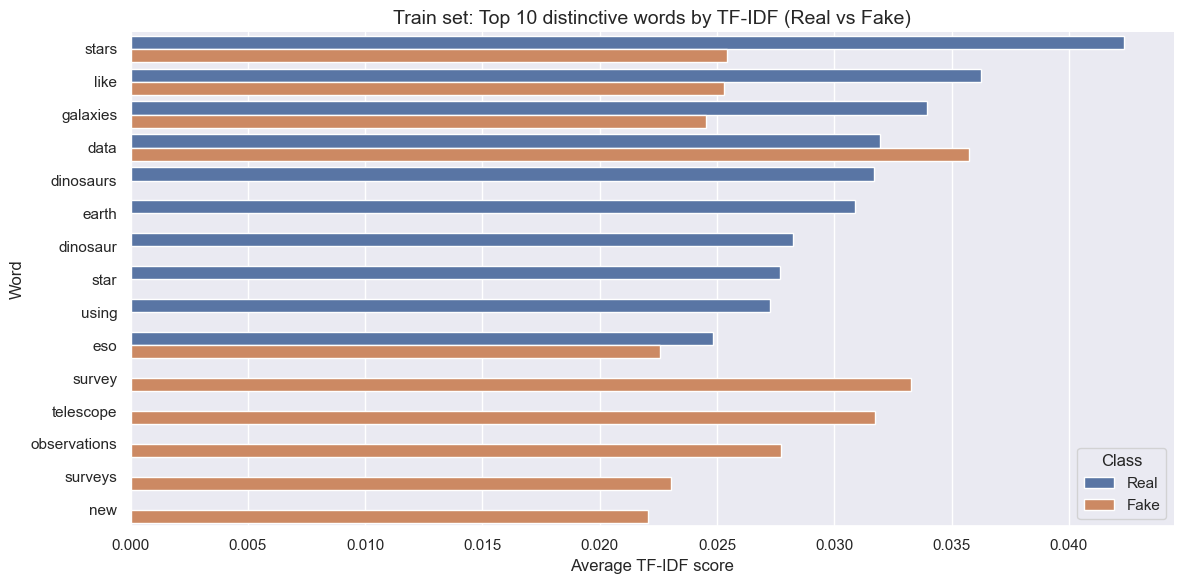

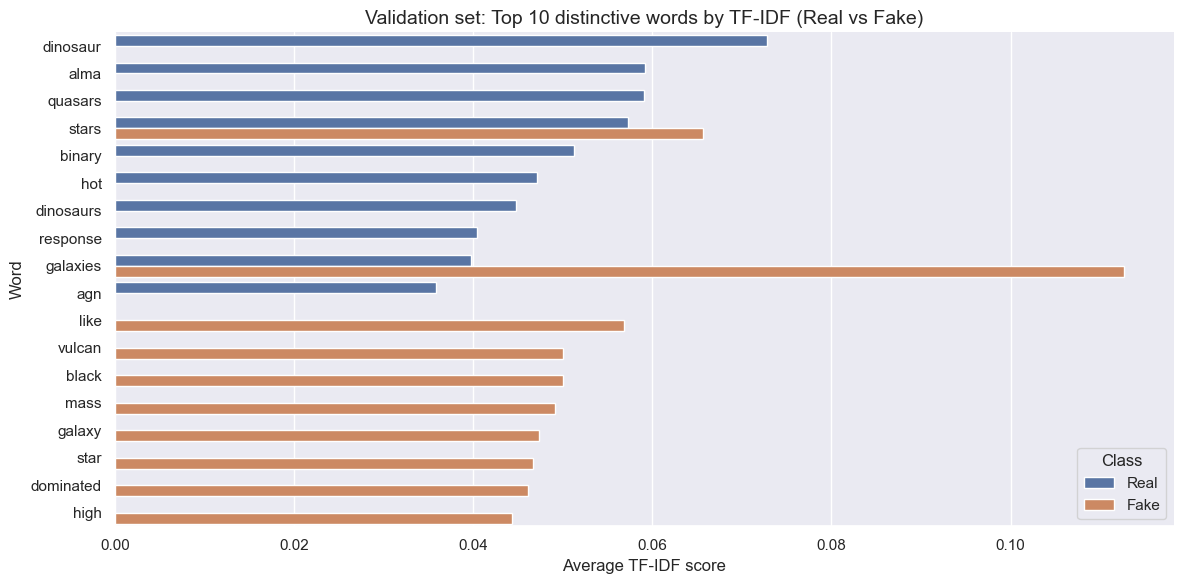

In [6]:
# Loop over train and validation sets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    # Combine both text files into one per article
    df['combined_text'] = df['file1_text'] + " " + df['file2_text']
    
    # Initialize TF-IDF
    vectorizer = TfidfVectorizer(max_features=5000, stop_words='english')
    X = vectorizer.fit_transform(df['combined_text'])
    feature_names = np.array(vectorizer.get_feature_names_out())
    
    # Create TF-IDF DataFrame
    tfidf_df = pd.DataFrame(X.toarray(), columns=feature_names)
    tfidf_df['label'] = df['real_text_id']
    tfidf_features = [col for col in tfidf_df.columns if col != 'label']
    
    # Compute average TF-IDF scores for each class
    real_means = (
        tfidf_df.loc[tfidf_df['label'] == 1, tfidf_features]
        .mean()
        .sort_values(ascending=False)[:10]
    )
    fake_means = (
        tfidf_df.loc[tfidf_df['label'] == 2, tfidf_features]
        .mean()
        .sort_values(ascending=False)[:10]
    )
    
    # Combine into one DataFrame for plotting
    top_real = pd.DataFrame({'word': real_means.index, 'tfidf': real_means.values, 'label': 'Real'})
    top_fake = pd.DataFrame({'word': fake_means.index, 'tfidf': fake_means.values, 'label': 'Fake'})
    top_words = pd.concat([top_real, top_fake])
    
    # Plot top TF-IDF words
    plt.figure(figsize=(12, 6))
    sns.barplot(
        data=top_words,
        x='tfidf', y='word',
        hue='label'
    )
    plt.title(f"{name.capitalize()} set: Top 10 distinctive words by TF-IDF (Real vs Fake)", fontsize=14)
    plt.xlabel("Average TF-IDF score")
    plt.ylabel("Word")
    plt.legend(title="Class", loc="lower right")
    sns.despine()
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"tfidf_top_words_{name}_real_vs_fake.png")
    plt.show()

- Real texts are more concentrated around concrete, scientific vocabulary (stars, galaxies, data, earth,...)
- Fake texts are more diffuse, referential, “science-sounding” words (survey, surveys, observations, new,...)

## Top CountVectorizer words for real vs fake

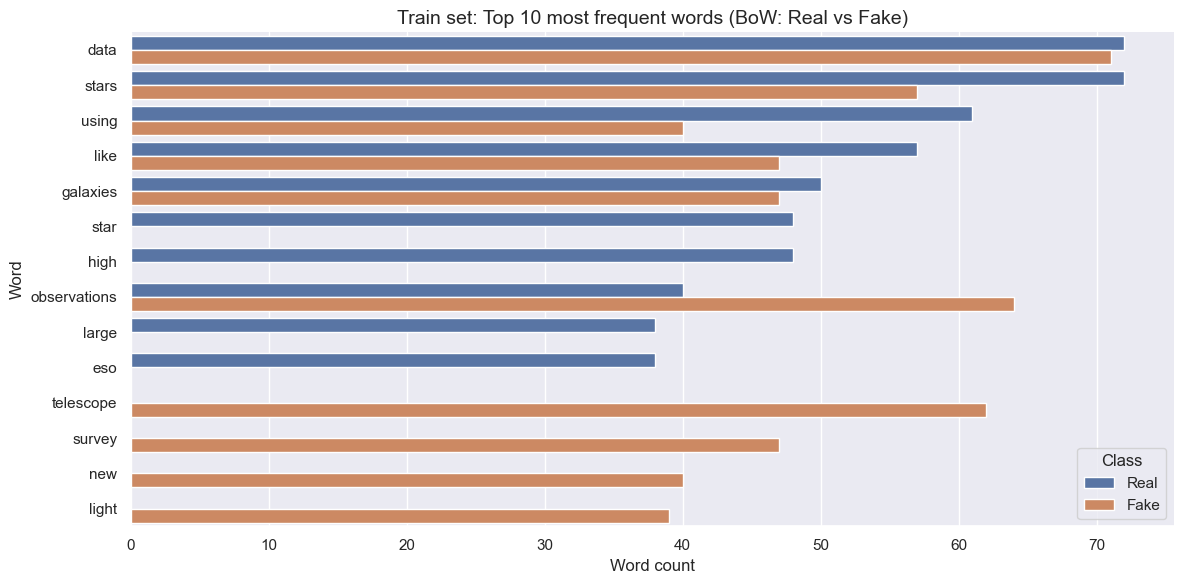

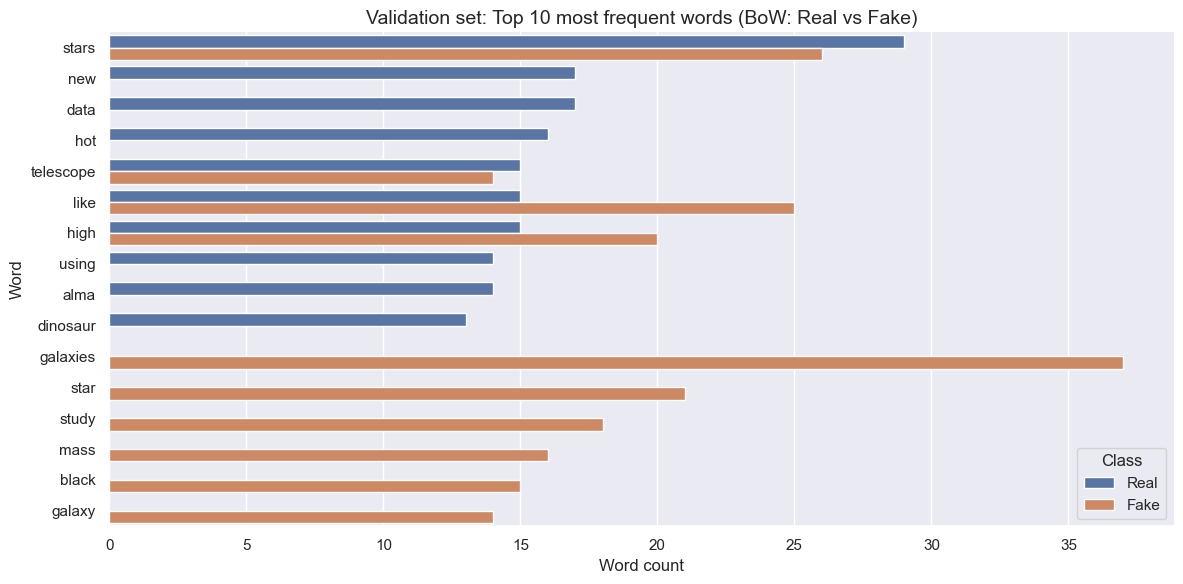

In [7]:
# Loop over train and validation sets
for df, name in zip([train_df, val_df], ['train', 'validation']):
    # Combine both text files into one per article
    df['combined_text'] = df['file1_text'] + " " + df['file2_text']
    
    # Initialize CountVectorizer
    bow_vectorizer = CountVectorizer(max_features=5000, stop_words='english')
    X_bow = bow_vectorizer.fit_transform(df['combined_text'])
    bow_feature_names = np.array(bow_vectorizer.get_feature_names_out())
    
    # Create a DataFrame for BoW features
    bow_df = pd.DataFrame(X_bow.toarray(), columns=bow_feature_names)
    bow_df['label'] = df['real_text_id']
    
    # Compute top 10 word counts per class
    real_counts = bow_df[bow_df['label'] == 1][bow_feature_names].sum().sort_values(ascending=False)[:10]
    fake_counts = bow_df[bow_df['label'] == 2][bow_feature_names].sum().sort_values(ascending=False)[:10]
    
    # Combine for plotting
    top_real_bow = pd.DataFrame({'word': real_counts.index, 'count': real_counts.values, 'label': 'Real'})
    top_fake_bow = pd.DataFrame({'word': fake_counts.index, 'count': fake_counts.values, 'label': 'Fake'})
    top_bow_words = pd.concat([top_real_bow, top_fake_bow])
    
    # Plot top words
    plt.figure(figsize=(12, 6))
    sns.barplot(data=top_bow_words, x='count', y='word', hue='label')
    plt.title(f"{name.capitalize()} set: Top 10 most frequent words (BoW: Real vs Fake)", fontsize=14)
    plt.xlabel("Word count")
    plt.ylabel("Word")
    plt.legend(title="Class", loc="lower right")
    sns.despine()
    plt.tight_layout()
    plt.savefig(PLOTS_PATH / f"bow_top_words_{name}_real_vs_fake.png")
    plt.show()

# Save the updated CSVs with new features

In [8]:
train_df.to_csv(config.PROCESSED_DATA_DIR / "train_eda_features.csv", index=False)
val_df.to_csv(config.PROCESSED_DATA_DIR / "val_eda_features.csv", index=False)
print("EDA features saved to processed folder")

EDA features saved to processed folder


# End of EDA notebook